# <font color='darkblue'>Setup</font> 

Todo:

Add in the threshold method to compare

## <font color='orange'>Packages</font> 

In [30]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter
import datetime as dt
from scipy.interpolate import griddata

# Plotting
import cartopy.crs as ccrs
from cartopy.feature import LAND
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Timing Processes and Progress
import time
from tqdm import tqdm

# make sure the figures plot inline rather than at the end
%matplotlib inline

## <font color='orange'>Functions</font> 

In [31]:
# display progress for long loops -----------------------------------------------------#
def progress_bar(itr,total):
    from time import sleep
    import sys
    sys.stdout.write('\r')
    
    if itr > 0:
        prev = np.round((itr-1)/total*100,2)
    else:
        prev = 0
    
    curr = np.round(itr/total*100,2)
    if (curr != prev):
        # the exact output you're looking for:
#         sys.stdout.write('[%-2s] %d%%' % ('='*int(curr), curr))
        sys.stdout.write('%d%%' % (curr))
        sys.stdout.flush()

# filtering a 2D matrix ---------------------------------------------------------------#
def gaus_filter_nan(img,sigma = 1):
    # import required packages
    from astropy.convolution import convolve
    from astropy.convolution import Gaussian2DKernel
    
    # create a kernal with std = 1
    kernel = Gaussian2DKernel(x_stddev=1)
    
    #convolve that with the 2d matrix
    img_conv = convolve(img, kernel)

    # set original nan points back to nans
    img_conv[np.isnan(img)] = np.nan

    return img_conv

# put coastlines on map and set xy limits ---------------------------------------------#
def add_land(ax,bounds= [35,120,-20,30]):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 1)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

# mask coastlines ---------------------------------------------------------------------#
def mask_coast(c_lon,c_lat,bounds):
    data=xr.open_dataset('/tigress/GEOCLIM/LRGROUP/shared_data/pco2_flux_coastal_Roobaert/mask_ocean.nc')
    mask_coast=np.array(data.mask_coastal2).astype(int).T
    lat=np.array(data.latitude)
    lon=np.array(data.longitude)

    mask_lon=np.logical_and(lon>bounds[0],lon<bounds[1])
    mask_lat=np.logical_and(lat>bounds[2],lat<bounds[3])

    lon=lon[mask_lon]
    lat=lat[mask_lat]

    mask_coast=mask_coast[mask_lat]
    mask_coast=mask_coast[:,mask_lon]

    lonlon,latlat=np.meshgrid(lon,lat)

    # what are these for? I should probably fix it
    lon_dot=np.array([70,70])
    lat_dot=np.array([10,19.5])

    mask=[]
    for lo,la in zip(c_lon,c_lat):
        if len(lon[lon<=lo])>0 and len(lat[lat>=la])>0 and len(lon[lon>=lo])>0 and len(lat[lat<=la])>0:
            lon_lim=[lon[lon<=lo][-1],lon[lon>=lo][0]]
            lat_lim=[lat[lat<=la][-1],lat[lat>=la][0]]
            mask_lon=np.logical_or(lon==lon_lim[0],lon==lon_lim[1])
            mask_lat=np.logical_or(lat==lat_lim[0],lat==lat_lim[1])
            mask_tmp=mask_coast[mask_lat]
            mask_tmp=mask_tmp[:,mask_lon]
            mask.append(np.mean(mask_tmp)>0)
        else:
            mask.append(False)
    mask=np.array(mask)
    return mask

# create pcolormesh lat/lon vals ------------------------------------------------------#
def pcolor_xy(x,y):
    # extend longitude by 2
    x_extend = np.zeros(x.size+2)
    # fill in internal values
    x_extend[1:-1] = x # fill up with original values
    # fill in extra endpoints
    x_extend[0] = x[0]-np.diff(x)[0]
    x_extend[-1] = x[-1]+np.diff(x)[-1]
    # calculate the midpoints
    x_pcolormesh_midpoints = x_extend[:-1]+0.5*(np.diff(x_extend))

    # extend latitude by 2
    y_extend = np.zeros(y.size+2)
    # fill in internal values
    y_extend[1:-1] = y
    # fill in extra endpoints
    y_extend[0] = y[0]-np.diff(y)[0]
    y_extend[-1] = y[-1]+np.diff(y)[-1]
    # calculate the midpoints
    y_pcolormesh_midpoints = y_extend[:-1]+0.5*(np.diff(y_extend))
    
    return x_pcolormesh_midpoints,y_pcolormesh_midpoints
    
# binning for one variable ------------------------------------------------------------#
def latlonbin(invar,lat,lon,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
        ))

    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan
    
    invar_bincounts = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_bincounts[:] = np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        invar_BINNED[i[0],j[0]] = group.invar

        invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)   
        
        invar_bincounts[i[0],j[0]] = len(group.invar[np.isfinite(group.invar)]) 

    return np.array(invar_binned_ave,dtype = float),np.array(invar_bincounts,dtype = float),latbins,lonbins

# month of min OCD plus other vars  -----------------------------------------------------#
def latlonbin_min_OCD(OCD,TCD,doxy_upper,doxy_lower,lat,lon,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            doxy_upper = np.array(doxy_upper),
            doxy_lower = np.array(doxy_lower),
            OCD = np.array(OCD),
            TCD = np.array(TCD),
            lat= np.array(lat),
            lon= np.array(lon),
            month = np.array(OCD.time.dt.month)
        ))
    
    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    min_OCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_OCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_OCD_TCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_OCD_doxy_upper = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_OCD_doxy_lower = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan

    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        gpmonth = np.array(group.month)
        gpOCD = np.array(group.OCD)
        gpTCD = np.array(group.TCD)
        gpdoxy_upper = np.array(group.doxy_upper)
        gpdoxy_lower = np.array(group.doxy_lower)

        # find month of minimum OCD
        if ~np.isnan(np.nanmin(gpOCD)):
            
            min_OCD[i[0],j[0]] = np.nanmin(gpOCD)
            
            ind = np.nanargmin(gpOCD)
            
            min_OCD_month[i[0],j[0]] = gpmonth[ind]
            min_OCD_TCD[i[0],j[0]] = gpTCD[ind]       
            min_OCD_doxy_upper[i[0],j[0]] = gpdoxy_upper[ind]
            min_OCD_doxy_lower[i[0],j[0]] = gpdoxy_lower[ind]

    return(np.array(min_OCD,dtype = float),np.array(min_OCD_month,dtype = float),
           np.array(min_OCD_TCD,dtype = float),
           np.array(min_OCD_doxy_upper,dtype = float),
           np.array(min_OCD_doxy_lower,dtype = float),
           latbins,lonbins)

# month of min doxy plus other vars  -----------------------------------------------------#
def latlonbin_min_doxy(doxy,OCD,TCD,lat,lon,bounds,binwidth):
    import numpy as np
    
    doxy = np.nanmin(doxy,1)
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            doxy = np.array(doxy),
            OCD = np.array(OCD),
            TCD = np.array(TCD),
            lat= np.array(lat),
            lon= np.array(lon),
            month = np.array(OCD.time.dt.month)
        ))
    
    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    min_doxy = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_doxy_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_doxy_TCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_doxy_OCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan

    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        gpmonth = np.array(group.month)
        gpOCD = np.array(group.OCD)
        gpTCD = np.array(group.TCD)
        gpdoxy = np.array(group.doxy)

        # find month of minimum OCD
        if ~np.isnan(np.nanmin(gpdoxy)):
            
            min_doxy[i[0],j[0]] = np.nanmin(gpdoxy)
            
            ind = np.nanargmin(gpdoxy)
            
            min_doxy_month[i[0],j[0]] = gpmonth[ind]
            min_doxy_TCD[i[0],j[0]] = gpTCD[ind]  
            min_doxy_OCD[i[0],j[0]] = gpOCD[ind]    

    return(np.array(min_doxy,dtype = float),np.array(min_doxy_month,dtype = float),
           np.array(min_doxy_TCD,dtype = float),
           np.array(min_doxy_OCD,dtype = float),
           latbins,lonbins)

## <font color='orange'>Read Data</font> 

### <font color='lightblue'>Merged ARGO WOD GOSHIP</font> 

In [32]:
# get merged data from tigress
path_AWG = '../data/Merged/'
infn_AWG = 'Profiles_temp_psal_doxy_processed.nc'

ds_AWG = xr.open_dataset(path_AWG + infn_AWG)
ds_AWG

<xarray.Dataset>
Dimensions:  (pres: 201, time: 306118)
Coordinates:
    prof     (time) int32 ...
  * time     (time) datetime64[ns] 1827-10-30 1836-05-15 ... 2020-02-07
  * pres     (pres) int32 0 5 10 15 20 25 30 35 ... 970 975 980 985 990 995 1000
Data variables:
    temp     (time, pres) float32 ...
    psal     (time, pres) float32 ...
    doxy     (time, pres) float32 ...
    lat      (time) float32 ...
    lon      (time) float32 ...
    type     (time) int32 ...

In [33]:
ds_AWG.doxy.min()

<xarray.DataArray 'doxy' ()>
array(-0.499857)

Text(0, 0.5, 'min doxy')

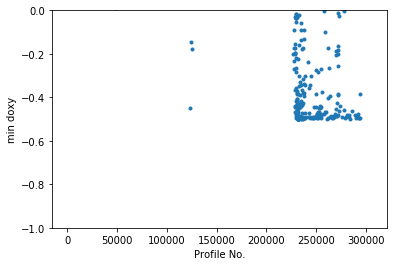

In [34]:
plt.plot(ds_AWG.doxy.min(dim = 'pres'),'.')
plt.ylim([-1,0])
plt.xlabel('Profile No.')
plt.ylabel('min doxy')

### <font color='lightblue'>WOA</font> 

In [35]:
# WOA
path_WOA="../data/WOA/"
infn_WOA = 'woa_awg_processed.nc'

ds_WOA = xr.open_dataset(path_WOA + infn_WOA)
ds_WOA

<xarray.Dataset>
Dimensions:  (month: 306118, pres: 201)
Coordinates:
  * month    (month) int64 10 5 12 2 5 2 2 3 3 3 2 2 ... 2 2 2 2 2 2 2 2 2 2 2 2
  * pres     (pres) float64 0.0 5.0 10.0 15.0 20.0 ... 985.0 990.0 995.0 1e+03
Data variables:
    temp     (month, pres) float64 ...
    psal     (month, pres) float64 ...
    doxy     (month, pres) float64 ...
    lon      (month) float64 ...
    lat      (month) float64 ...

# <font color='darkblue'>Find TCD and OCD</font> 

In [36]:
# Find centered dT/dp and dO/dp
temp_grad = ds_AWG.temp.differentiate("pres")/ds_AWG.pres.differentiate("pres")
doxy_grad = ds_AWG.doxy.differentiate("pres")/ds_AWG.pres.differentiate("pres")

pres_grad = ds_AWG.pres

temp_grad_WOA = ds_WOA.temp.differentiate("pres")/ds_WOA.pres.differentiate("pres")
doxy_grad_WOA = ds_WOA.doxy.differentiate("pres")/ds_WOA.pres.differentiate("pres")

pres_grad_WOA = ds_WOA.pres

#add to dataset - note no pressure difference since the average is the current one
ds_AWG['temp_grad'] = xr.DataArray(temp_grad,dims = ['time','pres_grad'],coords =[ds_AWG.time,pres_grad])
ds_AWG['doxy_grad'] = xr.DataArray(doxy_grad,dims = ['time','pres_grad'],coords =[ds_AWG.time,pres_grad])

ds_WOA['temp_grad'] = xr.DataArray(temp_grad_WOA,dims = ['month','pres_grad'],coords =[ds_WOA.month,pres_grad_WOA])
ds_WOA['doxy_grad'] = xr.DataArray(doxy_grad_WOA,dims = ['month','pres_grad'],coords =[ds_WOA.month,pres_grad_WOA])

# lightly smooth profiles
temp_grad_sm_10 = ds_AWG.temp_grad.rolling(pres_grad=13, center=True, min_periods = 3).mean()
doxy_grad_sm_10 = ds_AWG.doxy_grad.rolling(pres_grad=7, center=True, min_periods = 3).mean()

temp_grad_sm_10_WOA = ds_WOA.temp_grad.rolling(pres_grad=13, center=True, min_periods = 3).mean()
doxy_grad_sm_10_WOA = ds_WOA.doxy_grad.rolling(pres_grad=7, center=True, min_periods = 3).mean()

#add to dataset
ds_AWG['temp_grad_sm_10'] = xr.DataArray(temp_grad_sm_10,dims = ['time','pres_grad'],coords =[ds_AWG.time,pres_grad])
ds_AWG['doxy_grad_sm_10'] = xr.DataArray(doxy_grad_sm_10,dims = ['time','pres_grad'],coords =[ds_AWG.time,pres_grad])
ds_WOA['temp_grad_sm_10'] = xr.DataArray(temp_grad_sm_10_WOA,dims = ['month','pres_grad'],coords =[ds_WOA.month,pres_grad_WOA])
ds_WOA['doxy_grad_sm_10'] = xr.DataArray(doxy_grad_sm_10_WOA,dims = ['month','pres_grad'],coords =[ds_WOA.month,pres_grad_WOA])

#mask the nans in the arrays so that the functions work as expected 
temp_grad = np.ma.masked_array(ds_AWG.temp_grad, np.isnan(ds_AWG.temp_grad))
doxy_grad = np.ma.masked_array(ds_AWG.doxy_grad, np.isnan(ds_AWG.doxy_grad))

temp_grad_sm_10 = np.ma.masked_array(ds_AWG.temp_grad_sm_10, np.isnan(ds_AWG.temp_grad_sm_10))
doxy_grad_sm_10 = np.ma.masked_array(ds_AWG.doxy_grad_sm_10, np.isnan(ds_AWG.doxy_grad_sm_10))

temp_grad_WOA = np.ma.masked_array(ds_WOA.temp_grad, np.isnan(ds_WOA.temp_grad))
doxy_grad_WOA = np.ma.masked_array(ds_WOA.doxy_grad, np.isnan(ds_WOA.doxy_grad))

temp_grad_sm_10_WOA = np.ma.masked_array(ds_WOA.temp_grad_sm_10, np.isnan(ds_WOA.temp_grad_sm_10))
doxy_grad_sm_10_WOA = np.ma.masked_array(ds_WOA.doxy_grad_sm_10, np.isnan(ds_WOA.doxy_grad_sm_10))

# find data above 400dbars
upper_temp_grad = temp_grad[:,pres_grad<500]
upper_doxy_grad = doxy_grad[:,pres_grad<500]

upper_temp_grad_sm_10 = temp_grad_sm_10[:,pres_grad<500]
upper_doxy_grad_sm_10 = doxy_grad_sm_10[:,pres_grad<500]

upper_temp_grad_WOA = temp_grad_WOA[:,pres_grad_WOA<500]
upper_doxy_grad_WOA = doxy_grad_WOA[:,pres_grad_WOA<500]

upper_temp_grad_sm_10_WOA = temp_grad_sm_10_WOA[:,pres_grad_WOA<500]
upper_doxy_grad_sm_10_WOA = doxy_grad_sm_10_WOA[:,pres_grad_WOA<500]

# find maximum negative gradients (min grad)
upper_temp_grad_min_ind = np.nanargmin(upper_temp_grad,1)
upper_doxy_grad_min_ind = np.nanargmin(upper_doxy_grad,1)

upper_temp_grad_sm_10_min_ind = np.nanargmin(upper_temp_grad_sm_10,1)
upper_doxy_grad_sm_10_min_ind = np.nanargmin(upper_doxy_grad_sm_10,1)

upper_temp_grad_min_ind_WOA = np.nanargmin(upper_temp_grad_WOA,1)
upper_doxy_grad_min_ind_WOA = np.nanargmin(upper_doxy_grad_WOA,1)

upper_temp_grad_sm_10_min_ind_WOA = np.nanargmin(upper_temp_grad_sm_10_WOA,1)
upper_doxy_grad_sm_10_min_ind_WOA = np.nanargmin(upper_doxy_grad_sm_10_WOA,1)

# take the pressure value at the min index 
TCD = pres_grad[upper_temp_grad_min_ind]
OCD = pres_grad[upper_doxy_grad_min_ind]

TCD_sm_10 = pres_grad[upper_temp_grad_sm_10_min_ind]
OCD_sm_10 = pres_grad[upper_doxy_grad_sm_10_min_ind]

TCD_WOA = pres_grad_WOA[upper_temp_grad_min_ind_WOA]
OCD_WOA = pres_grad_WOA[upper_doxy_grad_min_ind_WOA]

TCD_sm_10_WOA = pres_grad_WOA[upper_temp_grad_sm_10_min_ind_WOA]
OCD_sm_10_WOA = pres_grad_WOA[upper_doxy_grad_sm_10_min_ind_WOA]

# set places with less than 10 pts above 500dbars to nan
temp_mind_pt_ind = np.sum(np.isfinite(upper_temp_grad),1) <10
doxy_mind_pt_ind = np.sum(np.isfinite(upper_doxy_grad),1) <10

temp_mind_pt_ind_sm_10 = np.sum(np.isfinite(upper_temp_grad_sm_10),1) <10
doxy_mind_pt_ind_sm_10 = np.sum(np.isfinite(upper_doxy_grad_sm_10),1) <10

TCD = TCD.where(~np.array(temp_mind_pt_ind))
OCD = OCD.where(~np.array(doxy_mind_pt_ind))

TCD_sm_10 = TCD_sm_10.where(~np.array(temp_mind_pt_ind_sm_10))
OCD_sm_10 = OCD_sm_10.where(~np.array(doxy_mind_pt_ind_sm_10))

temp_mind_pt_ind_WOA = np.sum(np.isfinite(upper_temp_grad_WOA),1) <10
doxy_mind_pt_ind_WOA = np.sum(np.isfinite(upper_doxy_grad_WOA),1) <10

temp_mind_pt_ind_sm_10_WOA = np.sum(np.isfinite(upper_temp_grad_sm_10_WOA),1) <10
doxy_mind_pt_ind_sm_10_WOA = np.sum(np.isfinite(upper_doxy_grad_sm_10_WOA),1) <10

TCD_WOA = TCD_WOA.where(~np.array(temp_mind_pt_ind_WOA))
OCD_WOA = OCD_WOA.where(~np.array(doxy_mind_pt_ind_WOA))

TCD_sm_10_WOA = TCD_sm_10_WOA.where(~np.array(temp_mind_pt_ind_sm_10_WOA))
OCD_sm_10_WOA = OCD_sm_10_WOA.where(~np.array(doxy_mind_pt_ind_sm_10_WOA))

# find anomalies
TCD_anom = np.array(TCD) - np.array(TCD_WOA)
OCD_anom = np.array(OCD) - np.array(OCD_WOA)

TCD_sm_10_anom = np.array(TCD_sm_10) - np.array(TCD_sm_10_WOA)
OCD_sm_10_anom = np.array(OCD_sm_10) - np.array(OCD_sm_10_WOA)

#add to dataset
ds_AWG['TCD'] = xr.DataArray(TCD,dims = ['time'],coords =[ds_AWG.time])
ds_AWG['OCD'] = xr.DataArray(OCD,dims = ['time'],coords =[ds_AWG.time])

ds_AWG['TCD_sm_10'] = xr.DataArray(TCD_sm_10,dims = ['time'],coords =[ds_AWG.time])
ds_AWG['OCD_sm_10'] = xr.DataArray(OCD_sm_10,dims = ['time'],coords =[ds_AWG.time])

ds_WOA['TCD'] = xr.DataArray(TCD_WOA,dims = ['month'],coords =[ds_WOA.month])
ds_WOA['OCD'] = xr.DataArray(OCD_WOA,dims = ['month'],coords =[ds_WOA.month])

ds_WOA['TCD_sm_10'] = xr.DataArray(TCD_sm_10_WOA,dims = ['month'],coords =[ds_WOA.month])
ds_WOA['OCD_sm_10'] = xr.DataArray(OCD_sm_10_WOA,dims = ['month'],coords =[ds_WOA.month])

ds_AWG['TCD_anom'] = xr.DataArray(TCD_anom,dims = ['time'],coords =[ds_AWG.time])
ds_AWG['OCD_anom'] = xr.DataArray(OCD_anom,dims = ['time'],coords =[ds_AWG.time])

ds_AWG['TCD_sm_10_anom'] = xr.DataArray(TCD_sm_10_anom,dims = ['time'],coords =[ds_AWG.time])
ds_AWG['OCD_sm_10_anom'] = xr.DataArray(OCD_sm_10_anom,dims = ['time'],coords =[ds_AWG.time])

# <font color='darkblue'>Gradient Scatterplots</font> 

## <font color='orange'>Merged</font> 

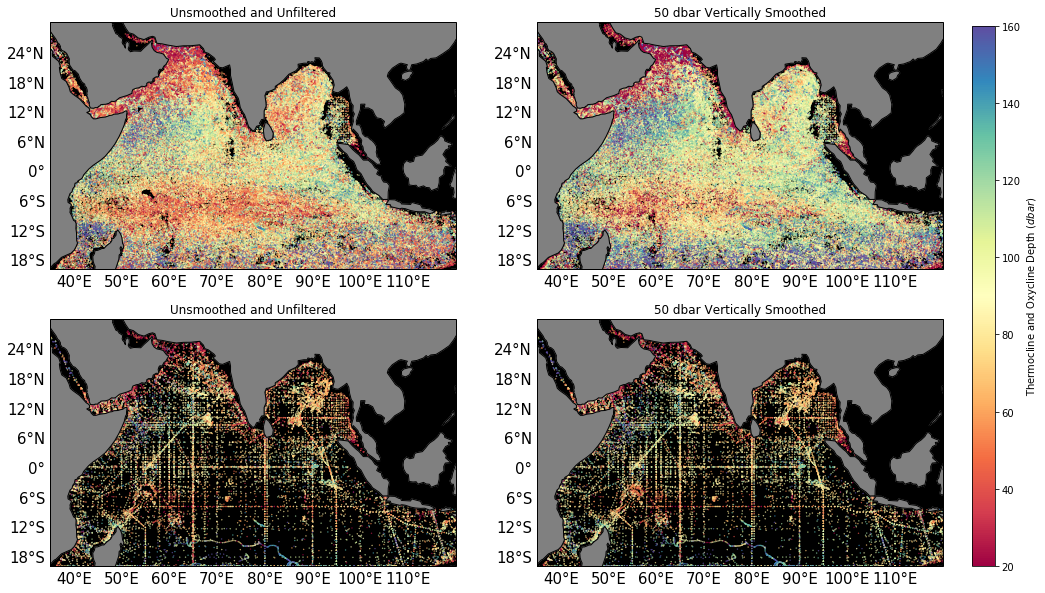

In [37]:
# Plotting Full Indian Ocean

# limits 
cmin = 20
cmax = 160
bounds = [35,120,-20,30]
sz = .5
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(ds_AWG.lon,ds_AWG.lat,s=sz,marker = '.',c=ds_AWG.TCD,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_title('Unsmoothed and Unfiltered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')


p2 = axes[0,1].scatter(ds_AWG.lon,ds_AWG.lat,s=sz,marker = '.',c=ds_AWG.TCD_sm_10,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('50 dbar Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].scatter(ds_AWG.lon,ds_AWG.lat,s=sz,marker = '.',c=ds_AWG.OCD,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_title('Unsmoothed and Unfiltered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')


p5 = axes[1,1].scatter(ds_AWG.lon,ds_AWG.lat,s=sz,marker = '.',c=ds_AWG.OCD_sm_10,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('50 dbar Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Thermocline and Oxycline Depth ($dbar$)')



## <font color='orange'>WOA</font> 

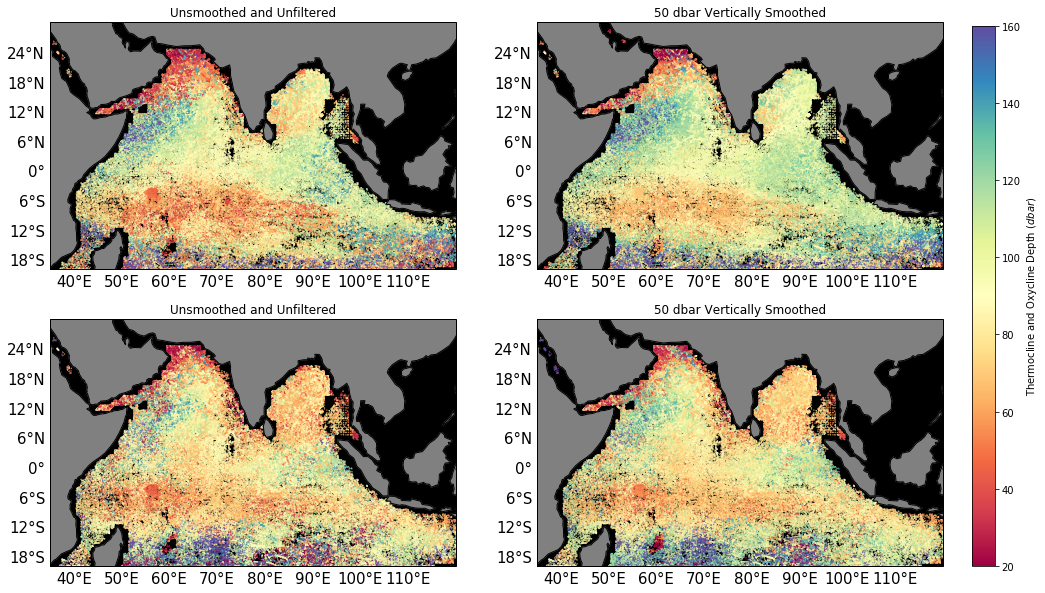

In [38]:
# limits 
cmin = 20
cmax = 160
bounds = [35,120,-20,30]
sz = .5
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(ds_WOA.lon,ds_WOA.lat,s=sz,marker = '.',c=ds_WOA.TCD,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_title('Unsmoothed and Unfiltered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')


p2 = axes[0,1].scatter(ds_WOA.lon,ds_WOA.lat,s=sz,marker = '.',c=ds_WOA.TCD_sm_10,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('50 dbar Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].scatter(ds_WOA.lon,ds_WOA.lat,s=sz,marker = '.',c=ds_WOA.OCD,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_title('Unsmoothed and Unfiltered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')


p5 = axes[1,1].scatter(ds_WOA.lon,ds_WOA.lat,s=sz,marker = '.',c=ds_WOA.OCD_sm_10,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('50 dbar Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Thermocline and Oxycline Depth ($dbar$)')




## <font color='orange'>TCD Anomalies</font> 

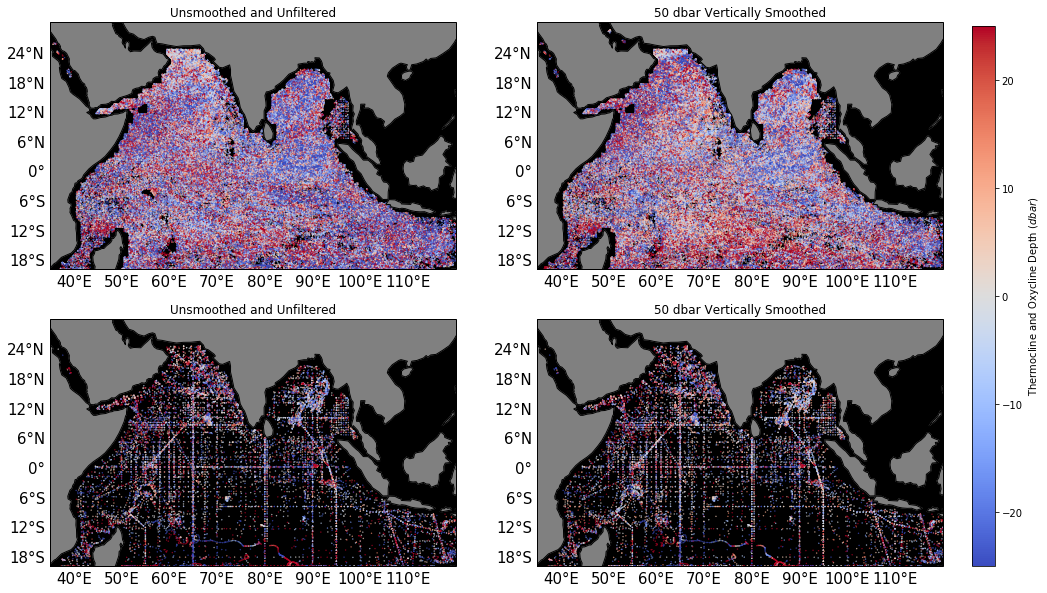

In [39]:
# Plotting Full Indian Ocean

# limits 
cmin = -25
cmax = 25
bounds = [35,120,-20,30]
sz = .5
cmap = plt.cm.coolwarm # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(ds_AWG.lon,ds_AWG.lat,s=sz,marker = '.',c=ds_AWG.TCD_anom,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_title('Unsmoothed and Unfiltered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')


p2 = axes[0,1].scatter(ds_AWG.lon,ds_AWG.lat,s=sz,marker = '.',c=ds_AWG.TCD_sm_10_anom,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('50 dbar Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].scatter(ds_AWG.lon,ds_AWG.lat,s=sz,marker = '.',c=ds_AWG.OCD_anom,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_title('Unsmoothed and Unfiltered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')


p5 = axes[1,1].scatter(ds_AWG.lon,ds_AWG.lat,s=sz,marker = '.',c=ds_AWG.OCD_sm_10_anom,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('50 dbar Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Thermocline and Oxycline Depth ($dbar$)')




# <font color='darkblue'>Binned Maps</font> 

https://stackoverflow.com/questions/40465026/groupby-bins-on-two-variables

## <font color='orange'>Merged</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice


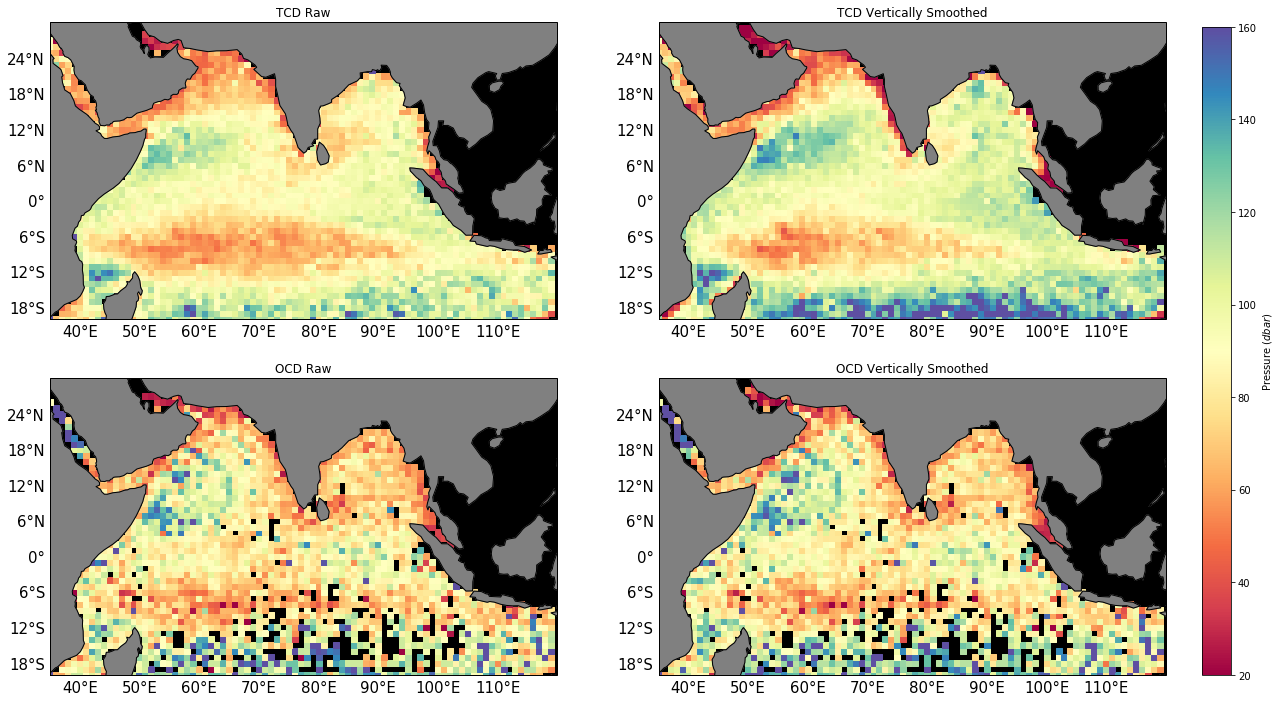

In [40]:
binwidth = 1
bounds = [35,120,-20,30]

# TCD/OCD Binned
TCD_binned_ave, TCD_bincounts,latbins,lonbins = latlonbin(ds_AWG.TCD,ds_AWG.lat,ds_AWG.lon,bounds,binwidth)
OCD_binned_ave,OCD_bincounts,_,_ = latlonbin(ds_AWG.OCD,ds_AWG.lat,ds_AWG.lon,bounds,binwidth)

TCD_sm_10_binned_ave,TCD_sm_10_bincounts,_,_ = latlonbin(ds_AWG.TCD_sm_10,ds_AWG.lat,ds_AWG.lon,bounds,binwidth)
OCD_sm_10_binned_ave,OCD_sm_10_bincounts,_,_ = latlonbin(ds_AWG.OCD_sm_10,ds_AWG.lat,ds_AWG.lon,bounds,binwidth)
    
# add to dataset
ds_AWG['TCD_binned_ave'] = xr.DataArray(TCD_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_binned_ave'] = xr.DataArray(OCD_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['TCD_bincounts'] = xr.DataArray(TCD_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_bincounts'] = xr.DataArray(OCD_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# add to dataset
ds_AWG['TCD_sm_10_binned_ave'] = xr.DataArray(TCD_sm_10_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_sm_10_binned_ave'] = xr.DataArray(OCD_sm_10_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['TCD_sm_10_bincounts'] = xr.DataArray(TCD_sm_10_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_sm_10_bincounts'] = xr.DataArray(OCD_sm_10_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# Plotting

xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 20
cmax =160
bounds = [35,120,-20,30]
s = 20
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(xx,yy,c = ds_AWG.TCD_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p = axes[0,0].pcolor(lonp,latp,ds_AWG.TCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.TCD_sm_10_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p2 = axes[0,1].pcolormesh(lonp,latp,ds_AWG.TCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.OCD_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p4 = axes[1,0].pcolormesh(lonp,latp,ds_AWG.OCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.OCD_sm_10_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p5 = axes[1,1].pcolormesh(lonp,latp,ds_AWG.OCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')


## <font color='orange'>WOA</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice


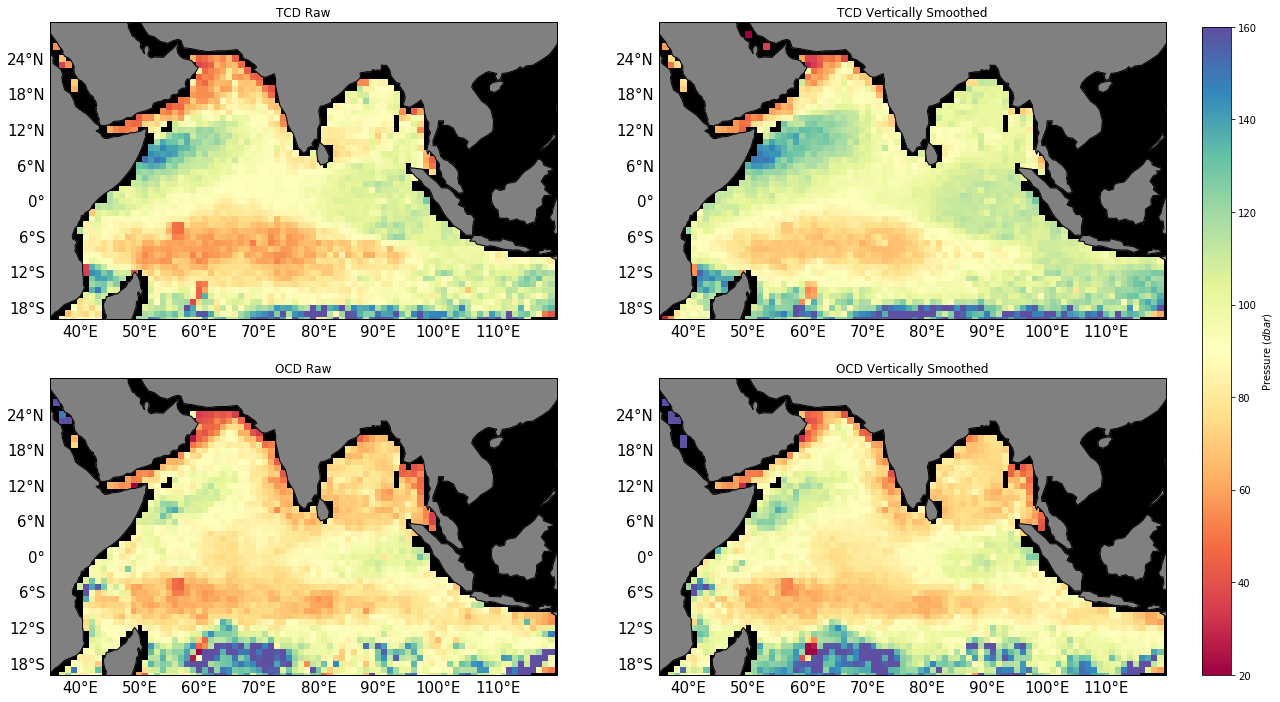

In [41]:
binwidth = 1
bounds = [35,120,-20,30]

# TCD/OCD Binned
TCD_binned_ave_WOA, TCD_bincounts_WOA,latbins_WOA,lonbins_WOA = latlonbin(ds_WOA.TCD,ds_WOA.lat,ds_WOA.lon,bounds,binwidth)
OCD_binned_ave_WOA,OCD_bincounts_WOA,_,_ = latlonbin(ds_WOA.OCD,ds_WOA.lat,ds_WOA.lon,bounds,binwidth)

TCD_sm_10_binned_ave_WOA,TCD_sm_10_bincounts_WOA,_,_ = latlonbin(ds_WOA.TCD_sm_10,ds_WOA.lat,ds_WOA.lon,bounds,binwidth)
OCD_sm_10_binned_ave_WOA,OCD_sm_10_bincounts_WOA,_,_ = latlonbin(ds_WOA.OCD_sm_10,ds_WOA.lat,ds_WOA.lon,bounds,binwidth)
    
# add to dataset
ds_WOA['TCD_binned_ave'] = xr.DataArray(TCD_binned_ave_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_WOA['OCD_binned_ave'] = xr.DataArray(OCD_binned_ave_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_WOA['TCD_bincounts'] = xr.DataArray(TCD_bincounts_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_WOA['OCD_bincounts'] = xr.DataArray(OCD_bincounts_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

# add to dataset
ds_WOA['TCD_sm_10_binned_ave'] = xr.DataArray(TCD_sm_10_binned_ave_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_WOA['OCD_sm_10_binned_ave'] = xr.DataArray(OCD_sm_10_binned_ave_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_WOA['TCD_sm_10_bincounts'] = xr.DataArray(TCD_sm_10_bincounts_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_WOA['OCD_sm_10_bincounts'] = xr.DataArray(OCD_sm_10_bincounts_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

# Plotting

xx,yy = np.meshgrid(ds_WOA.lonbins,ds_WOA.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 20
cmax =160
bounds = [35,120,-20,30]
s = 20
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(xx,yy,c = ds_WOA.TCD_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p = axes[0,0].pcolor(lonp,latp,ds_AWG.TCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].scatter(xx,yy,c = ds_WOA.TCD_sm_10_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p2 = axes[0,1].pcolormesh(lonp,latp,ds_AWG.TCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p3 = axes[1,0].scatter(xx,yy,c = ds_WOA.OCD_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p4 = axes[1,0].pcolormesh(lonp,latp,ds_AWG.OCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p4 = axes[1,1].scatter(xx,yy,c = ds_WOA.OCD_sm_10_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p5 = axes[1,1].pcolormesh(lonp,latp,ds_AWG.OCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## <font color='orange'>Anomaly</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice


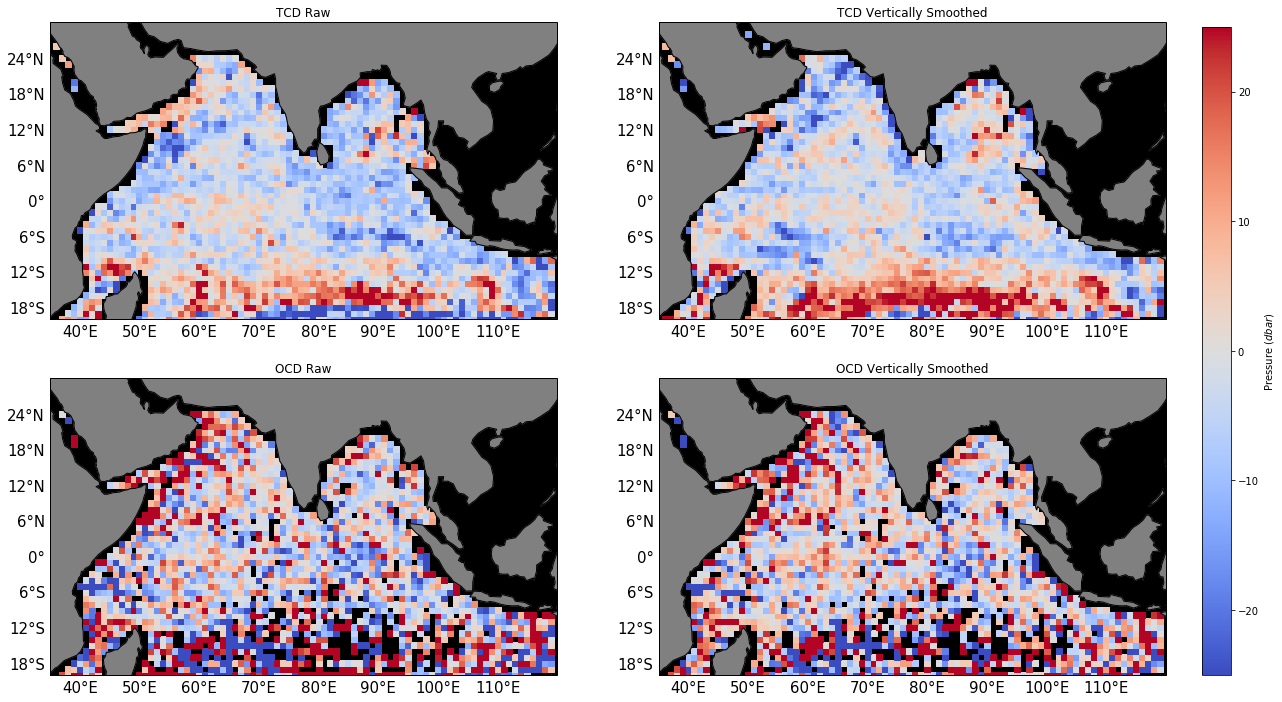

In [42]:
binwidth = 1
bounds = [35,120,-20,30]

# TCD/OCD Binned
TCD_anom_binned_ave, TCD_anom_bincounts,latbins,lonbins = latlonbin(ds_AWG.TCD_anom,ds_AWG.lat,ds_AWG.lon,bounds,binwidth)
OCD_anom_binned_ave, OCD_anom_bincounts,_,_ = latlonbin(ds_AWG.OCD_anom,ds_AWG.lat,ds_AWG.lon,bounds,binwidth)

TCD_sm_10_anom_binned_ave,TCD_sm_10_anom_bincounts,_,_ = latlonbin(ds_AWG.TCD_sm_10_anom,ds_AWG.lat,ds_AWG.lon,bounds,binwidth)
OCD_sm_10_anom_binned_ave,OCD_sm_10_anom_bincounts,_,_ = latlonbin(ds_AWG.OCD_sm_10_anom,ds_AWG.lat,ds_AWG.lon,bounds,binwidth)
    
# add to dataset
ds_AWG['TCD_anom_binned_ave'] = xr.DataArray(TCD_anom_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_anom_binned_ave'] = xr.DataArray(OCD_anom_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['TCD_anom_bincounts'] = xr.DataArray(TCD_anom_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_anom_bincounts'] = xr.DataArray(OCD_anom_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# add to dataset
ds_AWG['TCD_sm_10_anom_binned_ave'] = xr.DataArray(TCD_sm_10_anom_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_sm_10_anom_binned_ave'] = xr.DataArray(OCD_sm_10_anom_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['TCD_sm_10_anom_bincounts'] = xr.DataArray(TCD_sm_10_anom_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_sm_10_anom_bincounts'] = xr.DataArray(OCD_sm_10_anom_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# Plotting

xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = -25
cmax = 25
bounds = [35,120,-20,30]
s = 20
cmap = plt.cm.coolwarm # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(xx,yy,c = ds_AWG.TCD_anom_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p = axes[0,0].pcolor(lonp,latp,ds_AWG.TCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.TCD_sm_10_anom_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p2 = axes[0,1].pcolormesh(lonp,latp,ds_AWG.TCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.OCD_anom_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p4 = axes[1,0].pcolormesh(lonp,latp,ds_AWG.OCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.OCD_sm_10_anom_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p5 = axes[1,1].pcolormesh(lonp,latp,ds_AWG.OCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')



# <font color='darkblue'>Month of Minimum Oxygen/OCD</font> 

## <font color='orange'>Month of Minimum Oxygen</font> 

In [51]:
min_doxy,min_doxy_month,min_doxy_TCD,min_doxy_OCD,latbins,lonbins = latlonbin_min_doxy(ds_AWG.doxy,
                                                                                      ds_AWG.OCD,ds_AWG.TCD,
                                                                                      ds_AWG.lat,ds_AWG.lon,
                                                                                      bounds,binwidth)

# do smoothed version too


# add to dataset
ds_AWG['min_doxy'] = xr.DataArray(min_doxy,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_doxy_month'] = xr.DataArray(min_doxy_month,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_doxy_TCD'] = xr.DataArray(min_doxyTCD,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_doxy_OCD'] = xr.DataArray(min_doxy_OCD,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

TypeError: latlonbin_min_OCD() missing 1 required positional argument: 'binwidth'

In [ ]:
# Plotting
xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
xx = xx.flatten()
yy = yy.flatten()

bounds = [35,120,-20,30]
s = 20

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

# limits
cmin = 20
cmax = 160
cmap = plt.cm.Spectral
p = axes[0,0].scatter(xx,yy,c = ds_AWG.min_doxy.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('Minimum [O2]')
cbar = fig.colorbar(p,ax=axes[0,0], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

# limits
cmin = 1
cmax = 12
cmap = plt.cm.Spectral
p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.min_doxy_month.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('Month of Minimum [O2]')
cbar = fig.colorbar(p2,ax=axes[0,1], pad=0.04)
cbar.set_label('month')

# limits
cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.min_OCD_doxy_upper.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('[O2] 0-50 dbar')
cbar = fig.colorbar(p3,ax=axes[1,0], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.min_OCD_doxy_lower.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('[O2] 50-200 dbar')
cbar = fig.colorbar(p4,ax=axes[1,1], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

## <font color='orange'>Month of Minimum OCD</font> 

In [97]:
# find average for upper 0-50 dbar
doxy_upper = np.array(ds_AWG.doxy[:,ds_AWG.pres<50])
doxy_upper = np.nanmean(doxy_upper,1)

# find average for lower 55-200 dbar 
doxy_lower = np.array(ds_AWG.doxy[:,(ds_AWG.pres>50) & (ds_AWG.pres<200)])
doxy_lower = np.nanmean(doxy_lower,1)

min_OCD,min_OCD_month,min_OCD_TCD,min_OCD_doxy_upper,min_OCD_doxy_lower,latbins,lonbins = latlonbin_min_OCD(ds_AWG.OCD,ds_AWG.TCD,
                                                                                           doxy_upper,doxy_lower,
                                                                                           ds_AWG.lat,ds_AWG.lon,
                                                                                           bounds,binwidth)

# do smoothed version too


# add to dataset
ds_AWG['min_OCD'] = xr.DataArray(min_OCD,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_month'] = xr.DataArray(min_OCD_month,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_TCD'] = xr.DataArray(min_OCD_TCD,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_doxy_upper'] = xr.DataArray(min_OCD_doxy_upper,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_doxy_lower'] = xr.DataArray(min_OCD_doxy_lower,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: All-NaN slice encountered


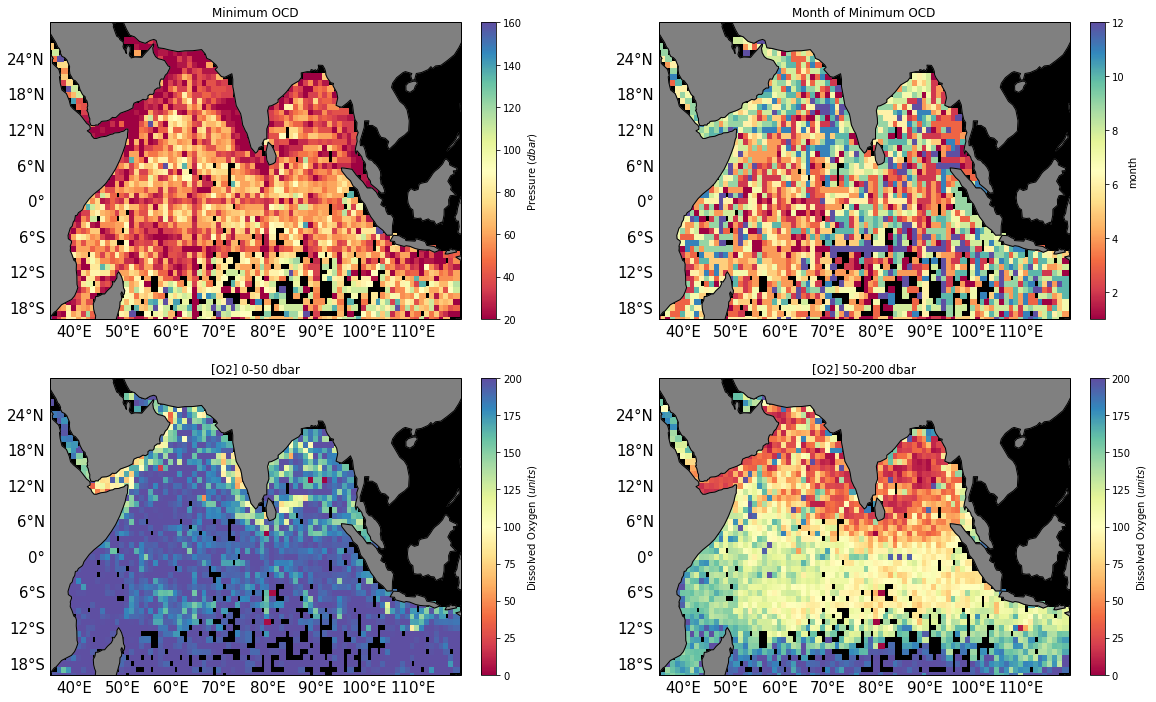

In [98]:
# Plotting
xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
xx = xx.flatten()
yy = yy.flatten()

bounds = [35,120,-20,30]
s = 20

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

# limits
cmin = 20
cmax = 160
cmap = plt.cm.Spectral
p = axes[0,0].scatter(xx,yy,c = ds_AWG.min_OCD.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('Minimum OCD')
cbar = fig.colorbar(p,ax=axes[0,0], pad=0.04)
cbar.set_label('Pressure ($dbar$)')

# limits
cmin = 1
cmax = 12
cmap = plt.cm.Spectral
p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.min_OCD_month.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('Month of Minimum OCD')
cbar = fig.colorbar(p2,ax=axes[0,1], pad=0.04)
cbar.set_label('month')

# limits
cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.min_OCD_doxy_upper.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('[O2] 0-50 dbar')
cbar = fig.colorbar(p3,ax=axes[1,0], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.min_OCD_doxy_lower.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('[O2] 50-200 dbar')
cbar = fig.colorbar(p4,ax=axes[1,1], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

## <font color='orange'>Month of Minimum OCD Anomaly</font> 

In [101]:
# find average for upper 0-50 dbar
doxy_upper = np.array(ds_AWG.doxy[:,ds_AWG.pres<50])
doxy_upper = np.nanmean(doxy_upper,1)

# find average for lower 55-200 dbar 
doxy_lower = np.array(ds_AWG.doxy[:,(ds_AWG.pres>50) & (ds_AWG.pres<200)])
doxy_lower = np.nanmean(doxy_lower,1)

min_OCD_anom,min_OCD_anom_month,min_OCD_anom_TCD_anom,min_OCD_anom_doxy_upper,min_OCD_anom_doxy_lower,latbins,lonbins = latlonbin_min_OCD(ds_AWG.OCD_anom,ds_AWG.TCD_anom,
                                                                                           doxy_upper,doxy_lower,
                                                                                           ds_AWG.lat,ds_AWG.lon,
                                                                                           bounds,binwidth)

# do smoothed version too


# add to dataset
ds_AWG['min_OCD_anom'] = xr.DataArray(min_OCD_anom,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_anom_month'] = xr.DataArray(min_OCD_anom_month,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_anom_TCD_anom'] = xr.DataArray(min_OCD_anom_TCD_anom,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_anom_doxy_upper'] = xr.DataArray(min_OCD_anom_doxy_upper,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_anom_doxy_lower'] = xr.DataArray(min_OCD_anom_doxy_lower,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: All-NaN slice encountered


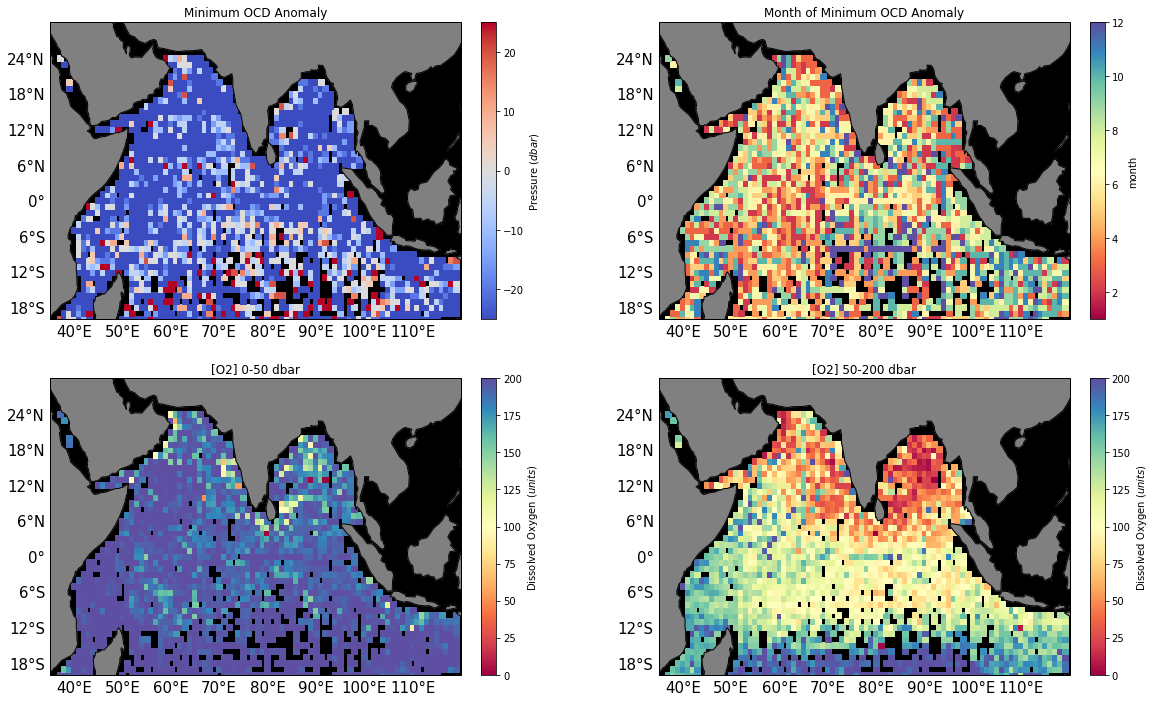

In [103]:
# Plotting
xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
xx = xx.flatten()
yy = yy.flatten()

bounds = [35,120,-20,30]
s = 20

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

# limits
cmin = -25
cmax = 25
cmap = plt.cm.coolwarm
p = axes[0,0].scatter(xx,yy,c = ds_AWG.min_OCD_anom.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('Minimum OCD Anomaly')
cbar = fig.colorbar(p,ax=axes[0,0], pad=0.04)
cbar.set_label('Pressure ($dbar$)')

# limits
cmin = 1
cmax = 12
cmap = plt.cm.Spectral
p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.min_OCD_anom_month.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('Month of Minimum OCD Anomaly')
cbar = fig.colorbar(p2,ax=axes[0,1], pad=0.04)
cbar.set_label('month')

# limits
cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.min_OCD_anom_doxy_upper.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('[O2] 0-50 dbar')
cbar = fig.colorbar(p3,ax=axes[1,0], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.min_OCD_anom_doxy_lower.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('[O2] 50-200 dbar')
cbar = fig.colorbar(p4,ax=axes[1,1], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

# <font color='darkblue'>Gaussian Filtered Binned Maps</font> 

## <font color='orange'>Merged</font> 

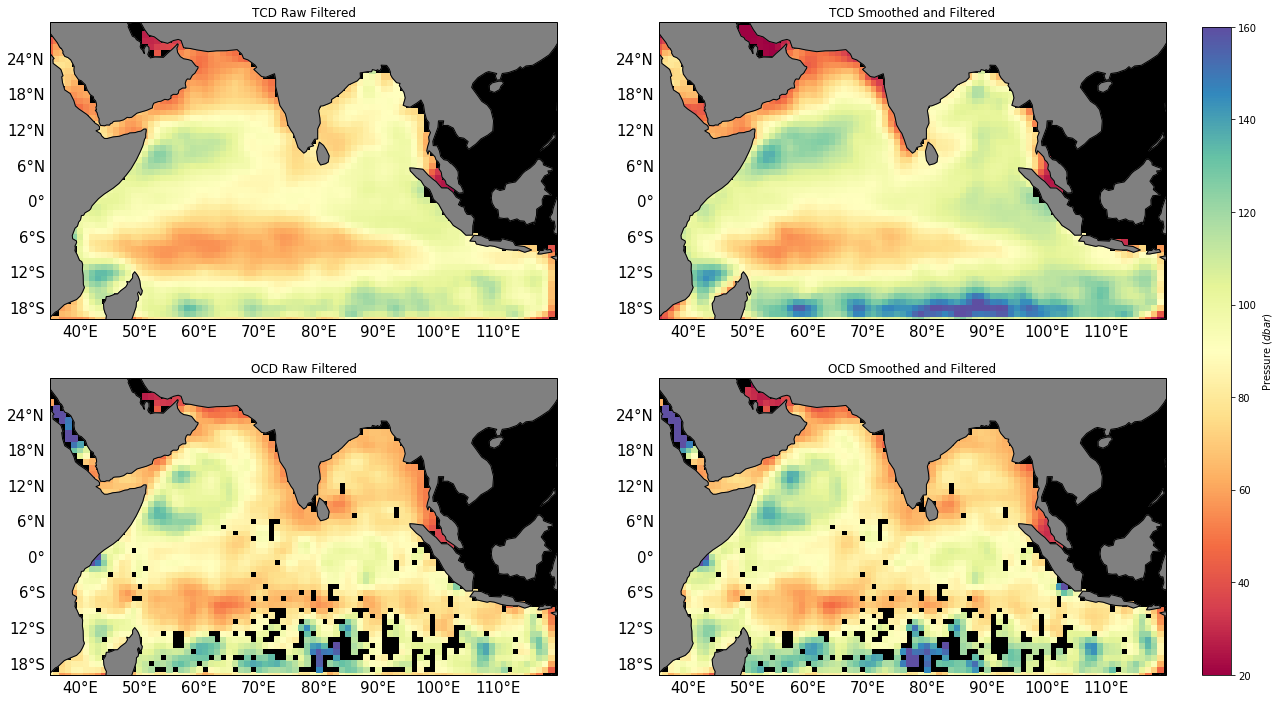

In [28]:
# add to dataset
ds_AWG['TCD_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.TCD_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.OCD_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['TCD_sm_10_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.TCD_sm_10_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_sm_10_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.OCD_sm_10_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# Plotting

xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 20
cmax = 160
bounds = [35,120,-20,30]
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(xx,yy,c = ds_AWG.TCD_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p = axes[0,0].pcolor(lonp,latp,ds_AWG.TCD_binned_ave_filt,cmap=cmap,vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw Filtered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.TCD_sm_10_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p2 = axes[0,1].pcolormesh(lonp,latp,ds_AWG.TCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Smoothed and Filtered')
axes[0,1].set_xlabel('Longitude')

p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.OCD_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p4 = axes[1,0].pcolormesh(lonp,latp,ds_AWG.OCD_binned_ave_filt,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw Filtered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.OCD_sm_10_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p5 = axes[1,1].pcolormesh(lonp,latp,ds_AWG.OCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Smoothed and Filtered')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## <font color='orange'>WOA</font> 

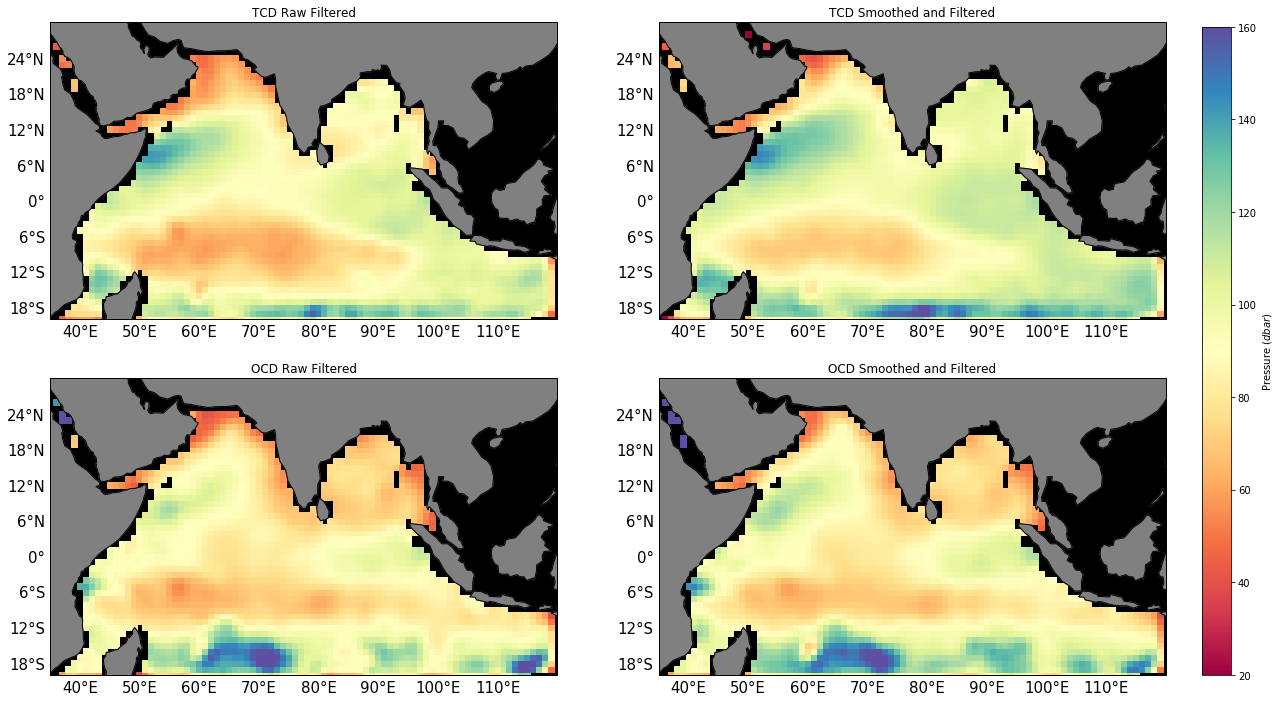

In [29]:
# add to dataset
ds_WOA['TCD_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_WOA.TCD_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_WOA['OCD_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_WOA.OCD_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_WOA['TCD_sm_10_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_WOA.TCD_sm_10_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_WOA['OCD_sm_10_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_WOA.OCD_sm_10_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# Plotting

xx,yy = np.meshgrid(ds_WOA.lonbins,ds_WOA.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 20
cmax = 160
bounds = [35,120,-20,30]
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(xx,yy,c = ds_WOA.TCD_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p = axes[0,0].pcolor(lonp,latp,ds_AWG.TCD_binned_ave_filt,cmap=cmap,vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw Filtered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].scatter(xx,yy,c = ds_WOA.TCD_sm_10_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p2 = axes[0,1].pcolormesh(lonp,latp,ds_AWG.TCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Smoothed and Filtered')
axes[0,1].set_xlabel('Longitude')

p3 = axes[1,0].scatter(xx,yy,c = ds_WOA.OCD_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p4 = axes[1,0].pcolormesh(lonp,latp,ds_AWG.OCD_binned_ave_filt,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw Filtered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p4 = axes[1,1].scatter(xx,yy,c = ds_WOA.OCD_sm_10_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p5 = axes[1,1].pcolormesh(lonp,latp,ds_AWG.OCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Smoothed and Filtered')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## <font color='orange'>Anomaly</font> 

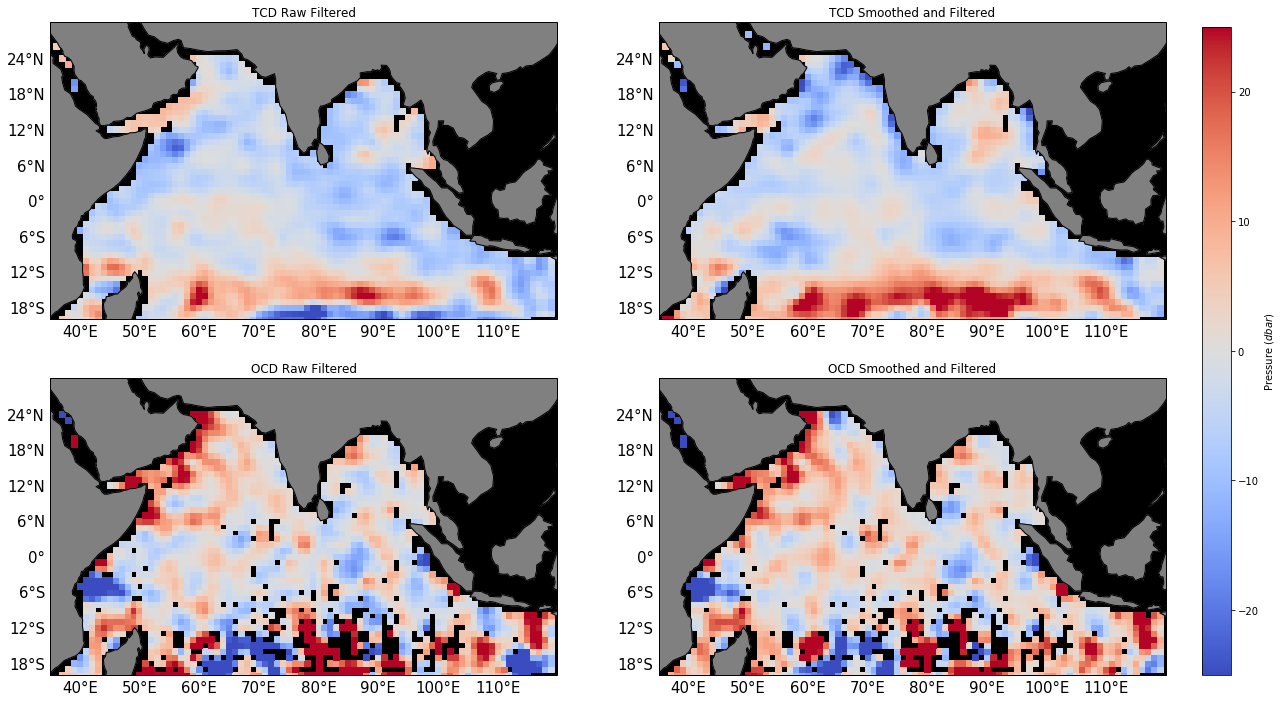

In [30]:
# add to dataset
ds_AWG['TCD_anom_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.TCD_anom_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_anom_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.OCD_anom_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['TCD_sm_10_anom_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.TCD_sm_10_anom_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_sm_10_anom_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.OCD_sm_10_anom_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# Plotting

xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = -25
cmax = 25
bounds = [35,120,-20,30]
cmap = plt.cm.coolwarm # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(xx,yy,c = ds_AWG.TCD_anom_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p = axes[0,0].pcolor(lonp,latp,ds_AWG.TCD_binned_ave_filt,cmap=cmap,vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw Filtered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.TCD_sm_10_anom_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p2 = axes[0,1].pcolormesh(lonp,latp,ds_AWG.TCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Smoothed and Filtered')
axes[0,1].set_xlabel('Longitude')

p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.OCD_anom_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p4 = axes[1,0].pcolormesh(lonp,latp,ds_AWG.OCD_binned_ave_filt,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw Filtered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.OCD_sm_10_anom_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p5 = axes[1,1].pcolormesh(lonp,latp,ds_AWG.OCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Smoothed and Filtered')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## <font color='orange'>Month of Minimum Oxygen</font> 

## <font color='orange'>Month of Minimum OCD</font> 

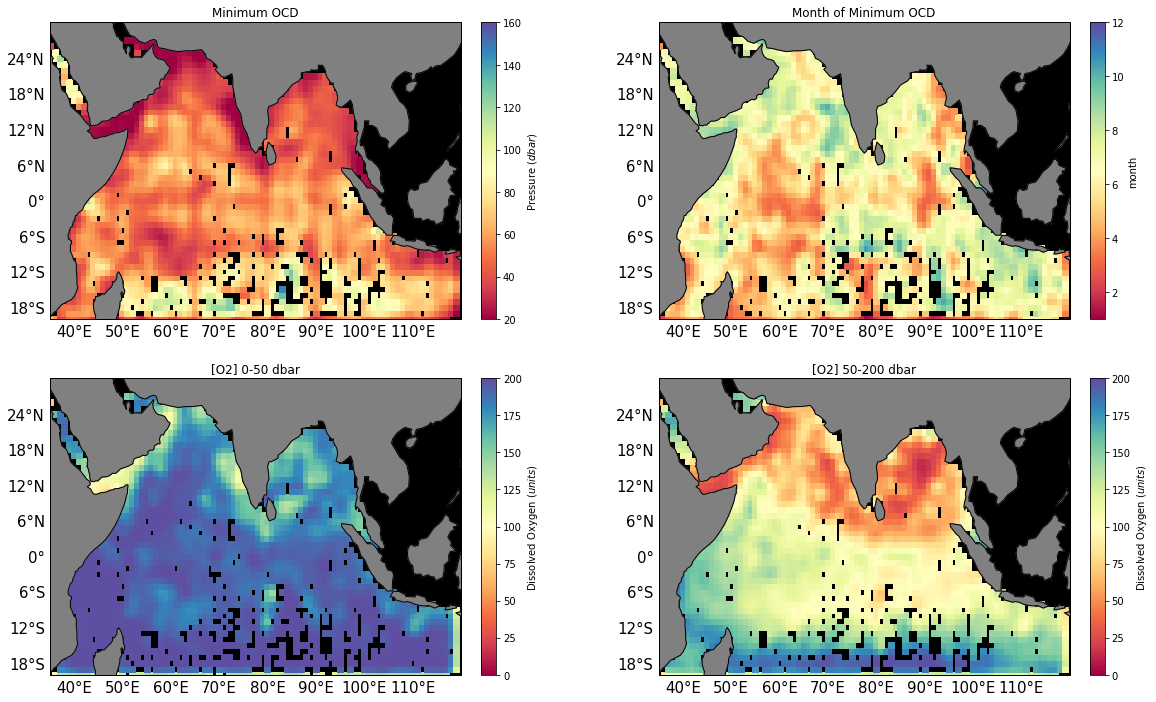

In [99]:
# add to dataset
ds_AWG['min_OCD_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_month_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_month,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_TCD_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_TCD,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_doxy_upper_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_doxy_upper,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_doxy_lower_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_doxy_lower,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# Plotting
xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
xx = xx.flatten()
yy = yy.flatten()

bounds = [35,120,-20,30]
s = 20

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

# limits
cmin = 20
cmax = 160
cmap = plt.cm.Spectral
p = axes[0,0].scatter(xx,yy,c = ds_AWG.min_OCD_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('Minimum OCD')
cbar = fig.colorbar(p,ax=axes[0,0], pad=0.04)
cbar.set_label('Pressure ($dbar$)')

# limits
cmin = 1
cmax = 12
cmap = plt.cm.Spectral
p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.min_OCD_month_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('Month of Minimum OCD')
cbar = fig.colorbar(p2,ax=axes[0,1], pad=0.04)
cbar.set_label('month')

# limits
cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.min_OCD_doxy_upper_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('[O2] 0-50 dbar')
cbar = fig.colorbar(p3,ax=axes[1,0], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.min_OCD_doxy_lower_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('[O2] 50-200 dbar')
cbar = fig.colorbar(p4,ax=axes[1,1], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

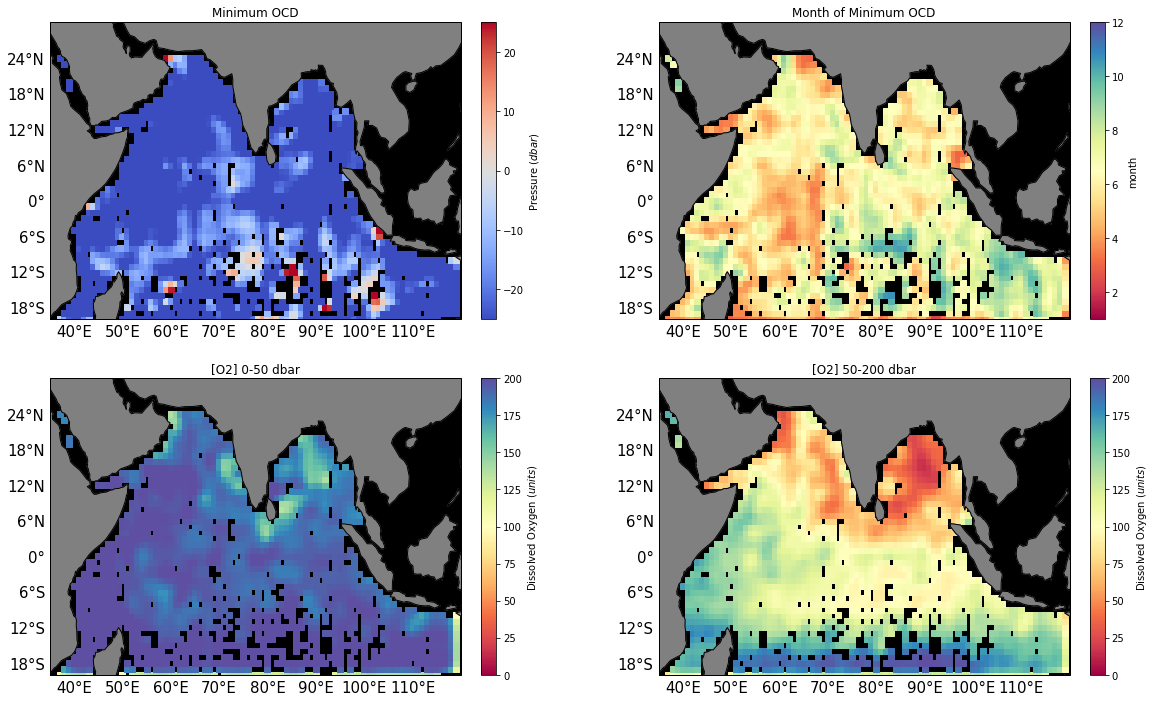

In [105]:
# add to dataset
ds_AWG['min_OCD_anom_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_anom,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_anom_month_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_anom_month,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_anom_TCD_anom_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_anom_TCD_anom,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_anom_doxy_upper_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_anom_doxy_upper,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_anom_doxy_lower_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_anom_doxy_lower,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# Plotting
xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
xx = xx.flatten()
yy = yy.flatten()

bounds = [35,120,-20,30]
s = 20

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

# limits
cmin = -25
cmax = 25
cmap = plt.cm.coolwarm
p = axes[0,0].scatter(xx,yy,c = ds_AWG.min_OCD_anom_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('Minimum OCD')
cbar = fig.colorbar(p,ax=axes[0,0], pad=0.04)
cbar.set_label('Pressure ($dbar$)')

# limits
cmin = 1
cmax = 12
cmap = plt.cm.Spectral
p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.min_OCD_anom_month_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('Month of Minimum OCD')
cbar = fig.colorbar(p2,ax=axes[0,1], pad=0.04)
cbar.set_label('month')

# limits
cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.min_OCD_anom_doxy_upper_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('[O2] 0-50 dbar')
cbar = fig.colorbar(p3,ax=axes[1,0], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.min_OCD_anom_doxy_lower_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('[O2] 50-200 dbar')
cbar = fig.colorbar(p4,ax=axes[1,1], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

In [ ]:
# this is where you left off
# tomorrow check the few places there is no woa data but there is merged data...that is plot the woa fields and make sure
# you were supposed to get something there. It might be that it couldnt find a TCD in the region...check it out.

# make the month of minimum oxygen plot and record the OCD and TCD for that value...

# figure out why there is negative oxygen data - remove it? 

# do that as a coastal map

# you should eventually tie this to the IOD index....maybe you can make maps that include only data from positive IOD years
# and negative etc...you should see some nice patterns there

# do the same for the Month of min oxygen...posID years it should be higher since you left the thermocline in BOB..

#you can make a coastl hovmuller here..first use the anomaly to find your coastlines since they are farther offshel, 
# then make the TCD OCD ones along with SLA...should show a nice patter for pos iod.neg iod years I hope


# add bincount maps


# save datasets



In [100]:
np.array(ds_AWG.doxy_min)

array([[-0.4998571, -0.4998571, -0.4998571, ..., -0.4998571, -0.4998571,
        -0.4998571],
       [-0.4998571, -0.4998571, -0.4998571, ..., -0.4998571, -0.4998571,
        -0.4998571],
       [       nan,        nan, -0.4998571, ..., -0.4998571, -0.4998571,
        -0.4998571],
       ...,
       [-0.4998571, -0.4998571,        nan, ...,        nan,        nan,
               nan],
       [-0.4998571, -0.4998571,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])